In [1]:
# -------------------------------------------------
# Step 0 读取 h5ad
# -------------------------------------------------
import anndata, numpy as np

adata = anndata.read_h5ad("../../data/z-scaled_w_normalized.h5ad")
X = adata.X            # 若是稀疏矩阵，后面会自动处理

# -------------------------------------------------
# Step 1 检查 z‑score 标准化
# -------------------------------------------------
#   对每个基因（列）计算均值 & 标准差
gene_means = np.asarray(X.mean(axis=0)).ravel()   # shape = (n_genes,)
gene_stds  = np.asarray(X.std(axis=0)).ravel()

print("基因均值（前 5 个）:", gene_means[:5])
print("基因标准差（前 5 个）:", gene_stds[:5])

is_centered   = np.allclose(gene_means, 0, atol=1e-2)
is_unitvar    = np.allclose(gene_stds,  1, atol=1e-2)

if is_centered and is_unitvar:
    print("✅ 数据看上去已做 z‑score 标准化")
else:
    print("⚠️  数据尚未完全标准化（或偏差较大），后续需执行 z‑scale")

# -------------------------------------------------
# Step 2 检查 log₂(x+1) 转换
# -------------------------------------------------
#   经验规则：log 转换后数值不会出现很大的整数，也不会有负值
vals_sample = np.asarray(X[:100].todense() if hasattr(X, "todense") else X[:100])

print("\n数值范围示例：",
      f"min={vals_sample.min():.2f}, 25%={np.percentile(vals_sample,25):.2f}, "
      f"median={np.median(vals_sample):.2f}, 75%={np.percentile(vals_sample,75):.2f}, "
      f"max={vals_sample.max():.2f}")

if vals_sample.min() < 0:
    print("⚠️  存在负值 → 数据应该尚未进行 log2(x+1) 变换")
elif vals_sample.max() > 100:
    print("⚠️  最大值非常大 → 很可能仍是原始计数，需先做 log2(x+1)")
else:
    print("✅ 数值分布符合 log2(x+1) 后的常见范围")

# -------------------------------------------------
# 小结
# 根据上述两大检查结果：
#   - 两个 ✅  → 可直接进入 PCA
#   - 任一 ⚠️ → 按论文顺序补做 log2 → z‑scale，再进行 PCA


基因均值（前 5 个）: [-2.8413171e-03 -1.5472946e-02 -3.5268753e-03 -2.5529963e-09
 -7.5026829e-09]
基因标准差（前 5 个）: [0.96788394 0.78388786 0.9594752  0.9991255  0.9991253 ]
⚠️  数据尚未完全标准化（或偏差较大），后续需执行 z‑scale

数值范围示例： min=-5.43, 25%=-0.56, median=-0.20, 75%=0.25, max=10.00
⚠️  存在负值 → 数据应该尚未进行 log2(x+1) 变换


PC1 & PC2 Explained variance ratio: [0.08875334 0.06115792]


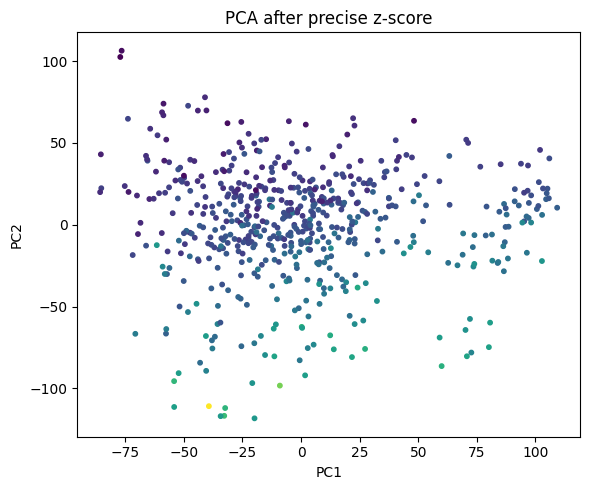

Clusters detected: 2
Silhouette score: 0.378


/opt/homebrew/Caskroom/miniconda/base/envs/sc/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/sc/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [2]:
# ========= 0. 读取 =========
import anndata, numpy as np, pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import hdbscan, matplotlib.pyplot as plt

adata = anndata.read_h5ad("../../data/z-scaled_w_normalized.h5ad")
X = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X   # 稠密矩阵

# ========= 1. 重新做 z‑score (ddof=0，样本数做分母) =========
X = (X - X.mean(axis=0)) / X.std(axis=0, ddof=0)

# ========= 2. PCA =========
pca = PCA(n_components=2, svd_solver="auto", random_state=42)
X_pca = pca.fit_transform(X)
print("PC1 & PC2 Explained variance ratio:", pca.explained_variance_ratio_)

# ========= 3. 可视化 =========
plt.figure(figsize=(6,5))
color = adata.obs.iloc[:,0] if adata.obs.shape[1] else "blue"
plt.scatter(X_pca[:,0], X_pca[:,1], s=10, c=color, cmap="viridis")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("PCA after precise z‑score")
plt.tight_layout(); plt.show()

# ========= 4. HDBSCAN + Silhouette =========
labels = hdbscan.HDBSCAN(min_cluster_size=9).fit_predict(X_pca)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Clusters detected: {n_clusters}")

if n_clusters > 1:
    sil = silhouette_score(X_pca, labels)
    print(f"Silhouette score: {sil:.3f}")
else:
    print("Too few clusters for silhouette score")


In [3]:
import numpy as np, hdbscan
from sklearn.metrics import silhouette_score

best_sil  = -1
best_size = None
best_lab  = None

for mcs in range(3, 15):          # 自己决定搜索范围
    labels = hdbscan.HDBSCAN(min_cluster_size=mcs).fit_predict(X_pca)
    # 至少要有 2 个真实簇才能算分
    if len(set(labels)) - (-1 in labels) < 2:
        continue
    sil = silhouette_score(X_pca, labels)
    if sil > best_sil:
        best_sil, best_size, best_lab = sil, mcs, labels

print(f"Best min_cluster_size = {best_size}, Silhouette = {best_sil:.3f}")


/opt/homebrew/Caskroom/miniconda/base/envs/sc/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/sc/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/sc/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/sc/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/sc/lib/python3.10/site-packages/sklea

Best min_cluster_size = 9, Silhouette = 0.378


/opt/homebrew/Caskroom/miniconda/base/envs/sc/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/sc/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [5]:
# ---------- 一次性检查所有 metadata 字段 ----------
import anndata, pandas as pd

adata = anndata.read_h5ad("../../data/z-scaled_w_normalized.h5ad")

print("📑  adata.obs 列表:")
print(adata.obs.columns.tolist())          # 打印所有字段名

print("\n👀  前 5 行预览:")
display(adata.obs.head())                  # 若在 Jupyter，可显示表格

# 如果列太多，只想看分类字段（类别 <= 20）：
cat_cols = [c for c in adata.obs.columns if adata.obs[c].nunique() <= 20]
print("\n🗂️  潜在的分类型字段 (n_unique ≤ 20):")
for c in cat_cols:
    print(f"  • {c}  ({adata.obs[c].nunique()} levels) → {adata.obs[c].unique()[:5]}")


📑  adata.obs 列表:
['nCount_RNA', 'nFeature_RNA', 'cases.submitter_id', 'sample_id', 'total_expr', 'cases.consent_type', 'cases.days_to_consent', 'cases.disease_type', 'cases.lost_to_followup', 'demographic.age_at_index', 'demographic.age_is_obfuscated', 'demographic.country_of_residence_at_enrollment', 'demographic.days_to_birth', 'demographic.days_to_death', 'demographic.demographic_id', 'demographic.ethnicity', 'demographic.gender', 'demographic.race', 'demographic.submitter_id', 'demographic.vital_status', 'diagnoses.age_at_diagnosis', 'diagnoses.ajcc_pathologic_m', 'diagnoses.ajcc_pathologic_n', 'diagnoses.ajcc_pathologic_stage', 'diagnoses.ajcc_pathologic_t', 'diagnoses.ajcc_staging_system_edition', 'diagnoses.classification_of_tumor', 'diagnoses.days_to_diagnosis', 'diagnoses.diagnosis_id.x', 'diagnoses.diagnosis_is_primary_disease', 'diagnoses.figo_stage', 'diagnoses.figo_staging_edition_year', 'diagnoses.icd_10_code', 'diagnoses.laterality', 'diagnoses.morphology', 'diagnoses.pr

,nCount_RNA,nFeature_RNA,cases.submitter_id,sample_id,total_expr,cases.consent_type,cases.days_to_consent,cases.disease_type,cases.lost_to_followup,demographic.age_at_index,...,follow_ups.progression_or_recurrence,follow_ups.progression_or_recurrence_anatomic_site,follow_ups.progression_or_recurrence_type,follow_ups.submitter_id,follow_ups.timepoint_category,diagnoses.diagnosis_id.y,diagnoses.submitter_id.y,pathology_details.consistent_pathology_review,pathology_details.pathology_detail_id,pathology_details.submitter_id
TCGA-05-4244-01A-01R-1107-07,2.002947e+07,17847,TCGA-05-4244,TCGA-05-4244-01A-01R-1107-07,2.002947e+07,Informed Consent,0,Adenomas and Adenocarcinomas,nan,70,...,nan,nan,nan,TCGA-05-4244_follow_up2,Follow-up,71222be8-573b-5d40-a15e-57649e0aec0a,TCGA-05-4244_diagnosis,Not Reported,77ce2281-945b-42ad-966e-6fe516f3f01d,TCGA-05-4244_pathology_detail
TCGA-05-4249-01A-01R-1107-07,1.898802e+07,17906,TCGA-05-4249,TCGA-05-4249-01A-01R-1107-07,1.898802e+07,Informed Consent,0,Adenomas and Adenocarcinomas,No,67,...,nan,nan,nan,TCGA-05-4249_follow_up3,Follow-up,c53e1e0c-f270-5739-badb-81ae50b90d15,TCGA-05-4249_diagnosis,Not Reported,d126d97f-f5ec-41c8-bd59-a3e920c65c8f,TCGA-05-4249_pathology_detail
TCGA-05-4250-01A-01R-1107-07,1.989284e+07,17678,TCGA-05-4250,TCGA-05-4250-01A-01R-1107-07,1.989284e+07,Informed Consent,0,Adenomas and Adenocarcinomas,nan,79,...,nan,nan,nan,TCGA-05-4250_follow_up,Last Contact,e3e1b5bf-7f8d-52dc-9a43-fcd54b78cb3d,TCGA-05-4250_diagnosis,Not Reported,271c9730-4251-403f-90a6-3f442aa1f395,TCGA-05-4250_pathology_detail
TCGA-05-4382-01A-01R-1206-07,2.018984e+07,18291,TCGA-05-4382,TCGA-05-4382-01A-01R-1206-07,2.018984e+07,Informed Consent,0,Adenomas and Adenocarcinomas,No,68,...,Yes,Not Reported,Distant,TCGA-05-4382_follow_up3,Post Initial Treatment,eece3e4c-7790-5d2a-bfa5-68bfb23ab769,TCGA-05-4382_diagnosis,Not Reported,57bc0ca4-55ac-4193-b60b-cf3d292a0a22,TCGA-05-4382_pathology_detail
TCGA-05-4384-01A-01R-1755-07,1.870713e+07,17624,TCGA-05-4384,TCGA-05-4384-01A-01R-1755-07,1.870713e+07,Informed Consent,0,Adenomas and Adenocarcinomas,No,66,...,Yes,Not Reported,Distant,TCGA-05-4384_follow_up4,Post Initial Treatment,13607a4a-be8f-5e01-abe5-4fd8a498e4d2,TCGA-05-4384_diagnosis,Not Reported,62a15f28-cdf4-431a-84d1-82ff57a69d2c,TCGA-05-4384_pathology_detail



🗂️  潜在的分类型字段 (n_unique ≤ 20):
  • cases.consent_type  (3 levels) → ['Informed Consent', 'Consent by Death', 'Consent Waiver']
Categories (3, object): ['Consent Waiver', 'Consent by Death', 'Informed Consent']
  • cases.disease_type  (4 levels) → ['Adenomas and Adenocarcinomas', 'Acinar Cell Neoplasms', 'Cystic, Mucinous and Serous Neoplasms', 'Ductal and Lobular Neoplasms']
Categories (4, object): ['Acinar Cell Neoplasms', 'Adenomas and Adenocarcinomas', 'Cystic, Mucinous and Serous Neoplasms', 'Ductal and Lobular Neoplasms']
  • cases.lost_to_followup  (3 levels) → ['nan', 'No', 'Yes']
Categories (3, object): ['No', 'Yes', 'nan']
  • demographic.age_is_obfuscated  (2 levels) → ['false', 'true']
Categories (2, object): ['false', 'true']
  • demographic.country_of_residence_at_enrollment  (9 levels) → ['Germany', 'Russia', 'United States', 'nan', 'Vietnam']
Categories (9, object): ['Australia', 'Canada', 'Germany', 'Romania', ..., 'Ukraine', 'United States', 'Vietnam', 'nan']
  • demog

/var/folders/sj/lmgylxc17t39pj1ckmq9w5bw0000gn/T/ipykernel_52288/1956577007.py:24: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


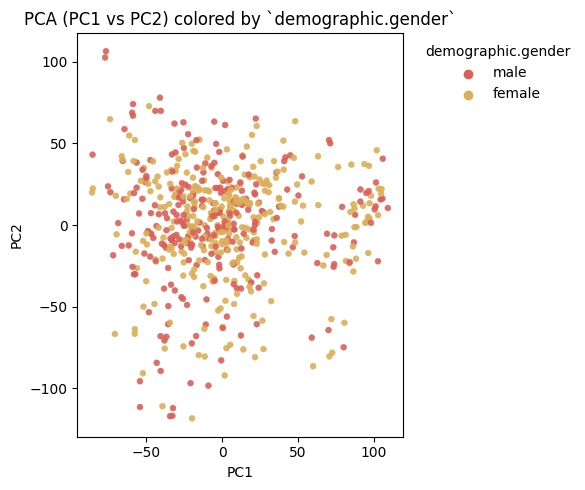

/var/folders/sj/lmgylxc17t39pj1ckmq9w5bw0000gn/T/ipykernel_52288/1956577007.py:24: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.scatterplot(


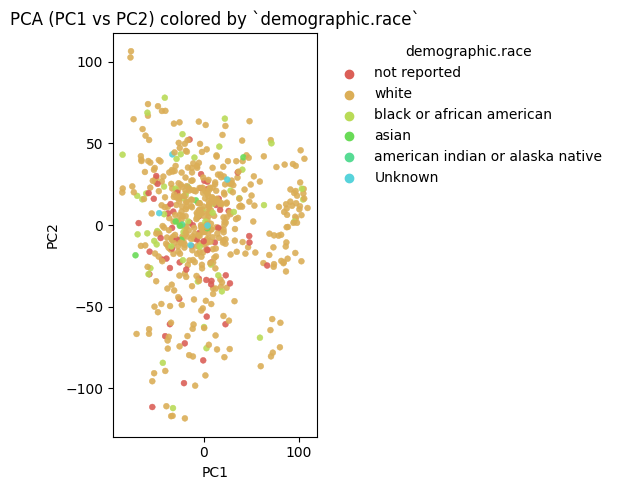

/var/folders/sj/lmgylxc17t39pj1ckmq9w5bw0000gn/T/ipykernel_52288/1956577007.py:24: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.scatterplot(


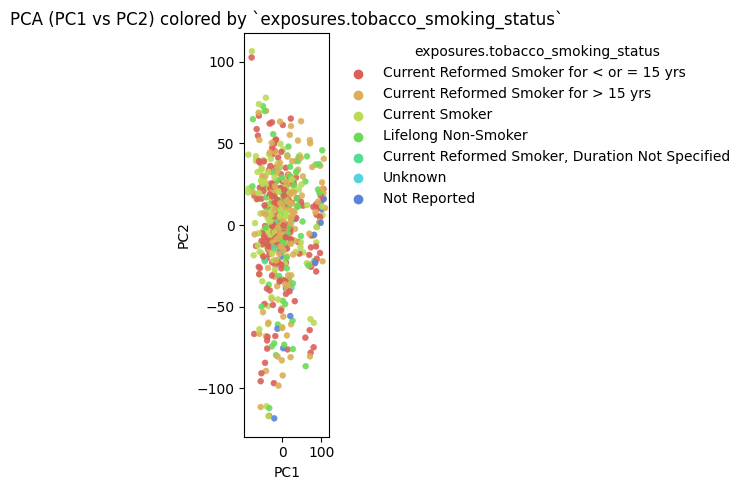

/var/folders/sj/lmgylxc17t39pj1ckmq9w5bw0000gn/T/ipykernel_52288/1956577007.py:24: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(


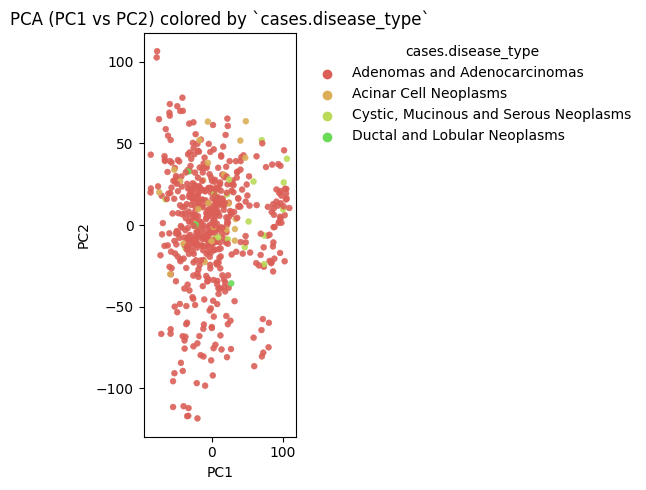

In [6]:
# ============ 依赖 ============
import anndata, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 已加载的 AnnData、已计算的 X_pca (n_samples × 2) 及 pca 对象
# 如果还没 pca 对象，可在此重新 fit:
# pca2 = PCA(n_components=2, random_state=42).fit(X)
# X_pca = pca2.transform(X)

meta_cols = [
    'demographic.gender',
    'demographic.race',
    'exposures.tobacco_smoking_status',
    'cases.disease_type'
]

palette = sns.color_palette("hls", 10)   # 最多 10 种离散色

for col in meta_cols:
    if col not in adata.obs.columns:
        print(f"[skip] {col} 不存在"); continue
    
    plt.figure(figsize=(6,5))
    sns.scatterplot(
        x=X_pca[:,0], y=X_pca[:,1],
        hue=adata.obs[col].astype(str),  # 转 str 保证离散
        palette=palette, s=18, edgecolor=None, alpha=0.9
    )
    plt.title(f"PCA (PC1 vs PC2) colored by `{col}`")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.legend(title=col, bbox_to_anchor=(1.03, 1), loc='upper left', frameon=False)
    plt.tight_layout()
    plt.show()


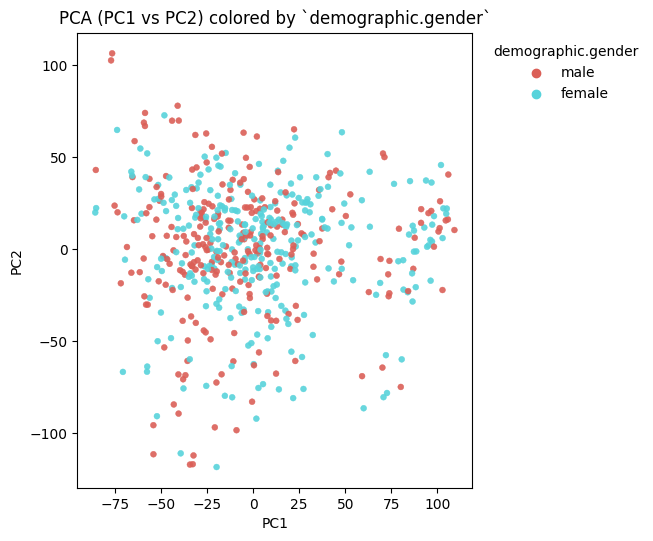

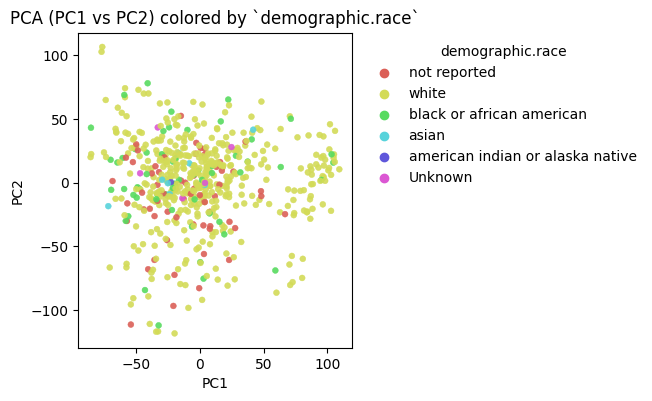

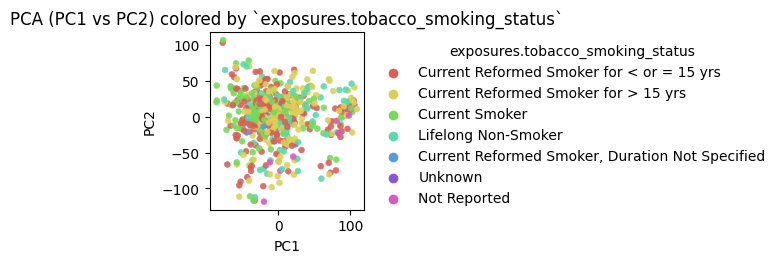

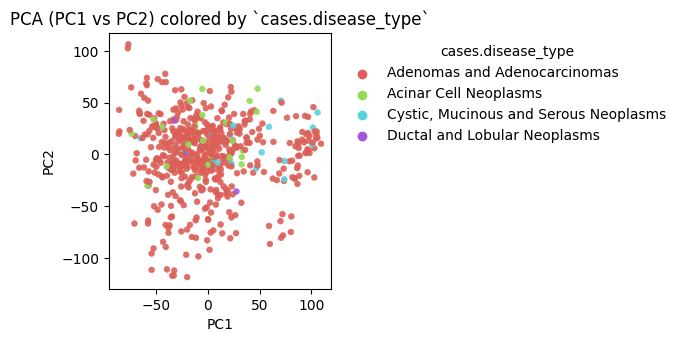

In [7]:
import seaborn as sns, matplotlib.pyplot as plt
import numpy as np

meta_cols = [
    'demographic.gender',
    'demographic.race',
    'exposures.tobacco_smoking_status',
    'cases.disease_type'
]

for col in meta_cols:
    if col not in adata.obs: 
        continue
    
    # 依据实际类别数生成对应颜色数
    n_cat = adata.obs[col].nunique()
    pal   = sns.color_palette("hls", n_cat)
    
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_aspect('equal')                    # 方形坐标系
    
    sns.scatterplot(
        x=X_pca[:,0], y=X_pca[:,1],
        hue=adata.obs[col].astype(str),
        palette=pal, s=18, edgecolor=None, alpha=0.9, ax=ax
    )
    ax.set_title(f"PCA (PC1 vs PC2) colored by `{col}`")
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
    ax.legend(title=col, bbox_to_anchor=(1.02,1), loc='upper left',
              frameon=False)
    plt.tight_layout(); plt.show()


IndexError: index 0 is out of bounds for axis 0 with size 0

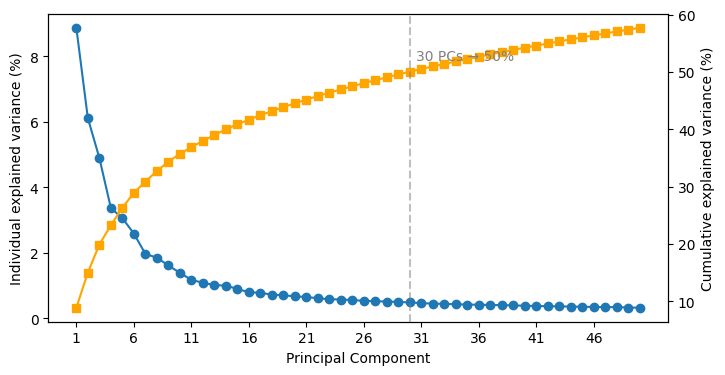

In [8]:
# -------- 计算前 50 PC ----------
pca50 = PCA(n_components=50, random_state=42).fit(X)
var_ratio = pca50.explained_variance_ratio_
cum_ratio = np.cumsum(var_ratio)

# -------- 绘图 ----------
fig, ax1 = plt.subplots(figsize=(8,4))

ax1.plot(range(1,51), var_ratio*100, marker='o', linewidth=1.5)
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Individual explained variance (%)')
ax1.set_xticks(range(1,51,5))

# 累计方差（双 y 轴）
ax2 = ax1.twinx()
ax2.plot(range(1,51), cum_ratio*100, marker='s', color='orange', linewidth=1.5)
ax2.set_ylabel('Cumulative explained variance (%)')

# 辅助线：50% 与 80%
for thr, clr in zip([0.5, 0.8], ['gray','gray']):
    pc_idx = np.where(cum_ratio >= thr)[0][0] + 1
    ax2.axvline(pc_idx, color=clr, linestyle="--", alpha=0.5)
    ax2.text(pc_idx+0.5, thr*100+2, f'{pc_idx} PCs → {thr*100:.0f}%', color=clr)

fig.suptitle('Elbow plot: variance explained by first 50 PCs')
fig.tight_layout()
plt.show()


IndexError: index 0 is out of bounds for axis 0 with size 0

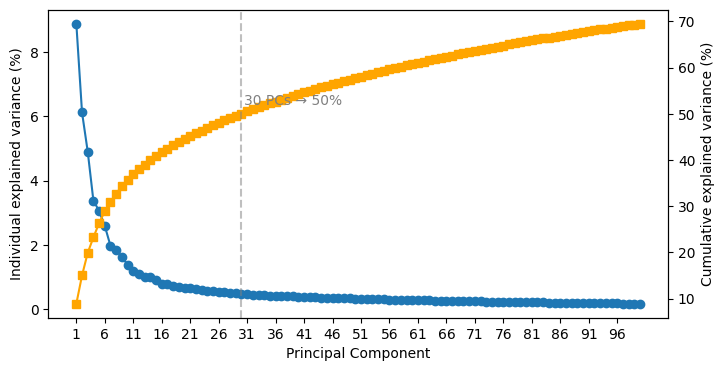

In [9]:
# -------- 计算前 100 PC ----------
pca100 = PCA(n_components=100, random_state=42).fit(X)
var_ratio = pca100.explained_variance_ratio_
cum_ratio = np.cumsum(var_ratio)

# -------- 绘图 ----------
fig, ax1 = plt.subplots(figsize=(8,4))

ax1.plot(range(1,101), var_ratio*100, marker='o', linewidth=1.5)
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Individual explained variance (%)')
ax1.set_xticks(range(1,100,5))

# 累计方差（双 y 轴）
ax2 = ax1.twinx()
ax2.plot(range(1,101), cum_ratio*100, marker='s', color='orange', linewidth=1.5)
ax2.set_ylabel('Cumulative explained variance (%)')

# 辅助线：50% 与 80%
for thr, clr in zip([0.5, 0.8], ['gray','gray']):
    pc_idx = np.where(cum_ratio >= thr)[0][0] + 1
    ax2.axvline(pc_idx, color=clr, linestyle="--", alpha=0.5)
    ax2.text(pc_idx+0.5, thr*100+2, f'{pc_idx} PCs → {thr*100:.0f}%', color=clr)

fig.suptitle('Elbow plot: variance explained by first 100 PCs')
fig.tight_layout()
plt.show()


In [22]:
!pip install --upgrade plotly


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ---------------------------------------- 0.0/14.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/14.8 MB ? eta -:--:--
      --------------------------------------- 0.3/14.8 MB ? eta -:--:--
     -- ------------------------------------- 0.8/14.8 MB 1.9 MB/s eta 0:00:08
     ----- ---------------------------------- 2.1/14.8 MB 3.4 MB/s eta 0:00:04
     ------------ --------------------------- 4.7/14.8 MB 5.8 MB/s eta 0:00:02
     --------------------- ------------------ 7.9/14.8 MB 7.7 MB/s eta 0:00:01
     ------------------------------- -------- 11.5/14.8 MB 9.4 MB/s eta 0:00:01
     --------------------------------------  14.7/14.8 MB 10.3 MB/s eta 0:00:01
     --------------------------------------- 14.8/14.8 MB 10.2 MB/s eta 0:00:00


In [23]:
import anndata, pandas as pd, numpy as np, plotly.express as px
from sklearn.decomposition import PCA

adata = anndata.read_h5ad("../../data/z-scaled_w_normalized.h5ad")

# ---- 1) 精确 z-score 已做；如果已有 X_pca 就直接用 ----
pca = PCA(n_components=2, random_state=42).fit(adata.X)
X_pca = pca.transform(adata.X)

# ---- 2) 组装 DataFrame 作为 Plotly 输入 ----
df = pd.DataFrame({
    "PC1": X_pca[:,0],
    "PC2": X_pca[:,1],
    "sample_id": adata.obs_names,                     # 行索引
    "gender": adata.obs["demographic.gender"].astype(str),
    "smoking": adata.obs["exposures.tobacco_smoking_status"].astype(str),
    "disease_type": adata.obs["cases.disease_type"].astype(str)
})

# ---- 3) 画交互散点 ----
fig = px.scatter(
    df, x="PC1", y="PC2",
    color="disease_type",                    # 也可换其它字段
    hover_data=["sample_id", "gender", "smoking", "disease_type"],
    title="Interactive PCA (hover for metadata)"
)
fig.update_traces(marker=dict(size=6, line=dict(width=0)))   # 小圆点
fig.write_html("PCA_interactive.html")       # 生成离线 html
fig.show()                                   # Jupyter 内直接弹窗
